# 1. 마르코프 결정 과정 (Markov Decision Process)

이 튜토리얼은 강화학습(Reinforcement Learning)의 핵심 개념인 MDP를 다룬다. OpenAI Gym의 최신 버전인 **Gymnasium** 라이브러리를 사용하여 간단한 미로(Maze) 환경을 구축하고, 상태(State), 행동(Action), 보상(Reward) 등의 기본 요소를 실습을 통해 학습한다.

### 0. 라이브러리 설치 및 설정

먼저 필요한 라이브러리를 불러온다. 기존 `gym`은 유지보수가 중단되었으므로, 이를 계승한 `gymnasium`을 사용한다. 또한 시각화를 위해 `matplotlib`을 설정한다.

> **참고:** 이 튜토리얼은 사용자가 정의한 `Maze` 환경을 사용한다고 가정한다. 만약 `envs` 모듈이 없다면, 아래의 **[참고] Maze 클래스 정의** 코드를 먼저 실행하여 환경을 생성해야 한다.

In [1]:
%pip install -q gymnasium 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# 주피터 노트북 내에서 플롯을 바로 표시하기 위한 설정
%matplotlib inline

In [3]:
# [참고] 사용자 정의 Maze 환경이 로컬에 'envs.py'로 없다면
# Gymnasium의 GridWorld 예제를 커스텀하거나 FrozenLake 등을 사용해야 한다.
# 여기서는 튜토리얼의 원활한 진행을 위해 원본 노트북의 Maze와 유사한
# Gymnasium 기반의 커스텀 환경 클래스를 약식으로 정의하여 사용한다.

from gymnasium import spaces

class Maze(gym.Env):
    def __init__(self):
        super().__init__()
        self.observation_space = spaces.MultiDiscrete([5, 5]) # 5x5 그리드
        self.action_space = spaces.Discrete(4) # 상, 우, 하, 좌
        self.state = np.array([0, 0])
        self.target = np.array([4, 4])
        self.render_mode = 'rgb_array'

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.array([0, 0])
        return self.state, {}

    def step(self, action):
        # 0: Up, 1: Right, 2: Down, 3: Left (원본 노트북 기준)
        # 좌표계: (row, col) -> (y, x)로 가정.
        # Up(0): row-1, Right(1): col+1, Down(2): row+1, Left(3): col-1
        moves = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}

        move = moves[action]
        next_state = self.state + np.array(move)

        # 그리드 밖으로 나가지 않도록 클리핑 (0~4 사이)
        next_state = np.clip(next_state, 0, 4)
        self.state = next_state

        # 목표 도달 여부 확인
        terminated = np.array_equal(self.state, self.target)
        truncated = False # 시간 제한 없음
        reward = -1.0 # 매 스텝마다 -1 보상

        return self.state, reward, terminated, truncated, {}

    def render(self):
        # 시각화를 위한 간단한 그리드 이미지 생성
        grid = np.zeros((5, 5, 3), dtype=np.uint8) + 255 # 흰색 배경
        # 현재 위치 (파란색)
        grid[self.state[0], self.state[1]] = [0, 0, 255]
        # 목표 위치 (녹색)
        grid[self.target[0], self.target[1]] = [0, 255, 0]

        # 이미지를 크게 보기 위해 확대
        grid_large = np.kron(grid, np.ones((40, 40, 1), dtype=np.uint8))
        return grid_large

---

## 1. Gymnasium 라이브러리 활용

Gymnasium(구 Gym)은 강화학습 연구를 위한 표준 라이브러리다. 이 라이브러리는 다음과 같은 다양한 환경에 대한 간단하고 통일된 인터페이스를 제공한다.

* 고전 제어 문제 (CartPole, Pendulum 등)
* 고전 비디오 게임 (Atari 등)
* 로봇 팔 제어 등

이 섹션에서는 제어 문제를 해결할 때 주로 사용하는 5가지 핵심 메서드를 살펴본다.

### 1.1 환경 생성: `make()`

환경을 생성하려면 `gym.make` 메서드에 환경의 ID를 전달하거나, 커스텀 환경 클래스의 인스턴스를 생성한다.

In [4]:
# Maze 환경 인스턴스 생성
# render_mode='rgb_array'는 화면에 그림을 그리기 위한 데이터 형식을 지정함
env = Maze()

### 1.2 초기화: `env.reset()`

이 메서드는 환경을 초기 상태로 되돌리고, 에이전트가 관찰할 수 있는 **초기 상태(Initial State)**를 반환한다.
*Gymnasium 변경사항:* `reset()`은 이제 `(observation, info)` 튜플을 반환한다.

In [5]:
# 초기 상태로 리셋. info는 추가 정보를 담은 딕셔너리다.
initial_state, info = env.reset()

print(f"새로운 에피소드가 시작되는 상태: {initial_state}")

새로운 에피소드가 시작되는 상태: [0 0]


### 1.3 시각화: `env.render()`

현재 환경의 상태를 시각적인 이미지(np.ndarray 형태)로 반환한다. 이를 통해 에이전트가 현재 어떤 상황에 있는지 눈으로 확인할 수 있다.

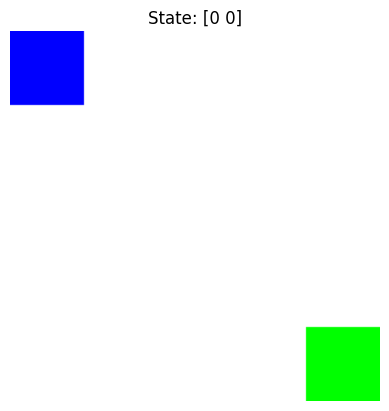

In [6]:
frame = env.render()
plt.axis('off')
plt.title(f"State: {initial_state}")
plt.imshow(frame)
plt.show()

### 1.4 행동 수행: `env.step()`

에이전트가 선택한 행동(Action)을 환경에 적용한다. 환경은 이 행동에 반응하여 다음 5가지 값을 반환한다.
*Gymnasium 변경사항:* 기존 4개 반환값에서 `terminated`와 `truncated`로 종료 조건이 세분화되어 5개를 반환한다.

1. **Next State**: 행동 결과로 이동한 다음 상태
2. **Reward**: 행동에 대해 받은 보상
3. **Terminated**: 에피소드 종료 여부 (목표 달성, 실패 등)
4. **Truncated**: 시간 제한 등으로 인한 강제 종료 여부
5. **Info**: 기타 보조 정보

In [7]:
action = 2 # 2번 행동 (아래로 이동) 선택
next_state, reward, terminated, truncated, info = env.step(action)

# 에피소드 종료 여부는 terminated 혹은 truncated가 True일 때
done = terminated or truncated

print(f"아래로 한 칸 이동 후 상태: {next_state}")
print(f"이동에 대한 보상: {reward}")
print("태스크 완료 여부:", "완료됨" if done else "완료되지 않음")

아래로 한 칸 이동 후 상태: [1 0]
이동에 대한 보상: -1.0
태스크 완료 여부: 완료되지 않음


### 1.5 새로운 상태 시각화

행동을 취한 후 변화된 상태를 다시 그려본다.

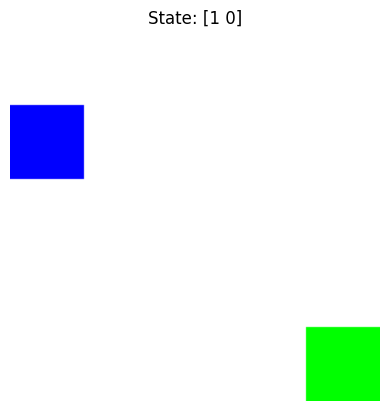

In [8]:
frame = env.render()

plt.axis('off')
plt.title(f"State: {next_state}")
plt.imshow(frame)
plt.show()

### 1.6 환경 종료: `env.close()`

작업이 끝나면 환경을 닫아 메모리 등의 리소스를 해제한다.

In [9]:
env.close()

---

## 2. 미로(Maze) 환경 분석: 출구 찾기

이 섹션에서는 이후 동적 계획법(DP), 몬테카를로(MC), 시간차(TD) 학습 등에서 계속 사용할 환경을 자세히 분석한다. 이 미로 환경은 다음과 같은 이유로 강화학습의 기초를 배우기에 적합하다.

* **상태의 수가 적음 (25개):** 계산이 간단하여 학습 과정을 이해하기 쉽다.
* **결정론적 전이:** 특정 행동을 하면 100% 확률로 의도한 상태로 이동한다 ().
* **보상 구조 단순화:** 에피소드가 끝날 때까지 모든 이동에 대해 동일한 보상(-1)을 받는다. 이는 최단 경로를 찾는 문제로 귀결된다.

이 환경을 통해 1강에서 배운 MDP의 핵심 개념들을 복습한다.

### 2.1 상태(State)와 상태 공간(State Space)

상태는 에이전트가 현재 위치한 행(row)과 열(column)을 나타내는 두 정수의 튜플이다. 범위는 [0, 4]이다.

상태 공간 는 가능한 모든 상태의 집합이며, 5x5 그리드이므로 총 25개의 요소를 가진다.

In [10]:
# 환경 재생성
env = Maze()
initial_state, _ = env.reset()

print(f"예시 - 초기 상태: {initial_state}")
print(f"상태 공간(State Space) 타입: {env.observation_space}")
# MultiDiscrete([5 5])는 첫 번째 차원 5개, 두 번째 차원 5개의 값을 가짐을 의미

예시 - 초기 상태: [0 0]
상태 공간(State Space) 타입: MultiDiscrete([5 5])


### 2.2 행동(Action)과 행동 공간(Action Space)

이 환경에는 4가지 행동이 있으며, 정수로 표현된다.

* 0: 위로 이동 (Up)
* 1: 오른쪽으로 이동 (Right)
* 2: 아래로 이동 (Down)
* 3: 왼쪽으로 이동 (Left)

`env.action_space`를 통해 행동 공간 정보를 확인할 수 있다. `Discrete(4)`는 0부터 3까지의 이산적인 값을 의미한다.

In [11]:
print(f"유효한 행동 예시 (샘플링): {env.action_space.sample()}")
print(f"행동 공간(Action Space) 타입: {env.action_space}")

유효한 행동 예시 (샘플링): 2
행동 공간(Action Space) 타입: Discrete(4)


### 2.3 궤적(Trajectory)과 에피소드(Episode)

**궤적(Trajectory)**은 한 상태에서 다른 상태로 이동하며 생성되는 시퀀스다.

코드로 3번의 움직임을 가진 궤적을 생성해본다.

In [12]:
env = Maze()
state, _ = env.reset()

trajectory = []
for _ in range(3):
    action = env.action_space.sample() # 무작위 행동 선택
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    trajectory.append([state, action, reward, done, next_state])
    state = next_state
env.close()

print(f"생성된 첫 번째 궤적:\n{trajectory}")

생성된 첫 번째 궤적:
[[array([0, 0]), np.int64(0), -1.0, False, array([0, 0])], [array([0, 0]), np.int64(3), -1.0, False, array([0, 0])], [array([0, 0]), np.int64(3), -1.0, False, array([0, 0])]]


**에피소드(Episode)**는 초기 상태에서 시작하여 종료 상태(Terminal State)에 도달할 때까지의 전체 궤적을 의미한다.

In [13]:
env = Maze()
state, _ = env.reset()

episode = []
done = False

# 종료될 때까지 반복 (주의: 랜덤 정책이므로 매우 오래 걸릴 수 있음)
# 무한 루프 방지를 위해 최대 스텝을 제한하는 것이 일반적이나, 여기선 원본 예제를 따름
step_count = 0
while not done and step_count < 1000: # 안전장치로 1000스텝 제한
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    episode.append([state, action, reward, done, next_state])
    state = next_state
    step_count += 1

env.close()

print(f"생성된 에피소드 길이: {len(episode)} 스텝")

생성된 에피소드 길이: 255 스텝


### 2.4 보상(Reward)과 반환값(Return)

**보상**은 에이전트가 상태 에서 행동 를 취했을 때 환경으로부터 받는 피드백이다.

In [14]:
env = Maze()
state, _ = env.reset()
action = env.action_space.sample()
_, reward, _, _, _ = env.step(action)
print(f"상태 {state}에서 행동 {action}을 취해 보상 {reward}를 얻음")

상태 [0 0]에서 행동 1을 취해 보상 -1.0를 얻음


**반환값(Return, )**은 시점 부터 에피소드가 끝날 때까지 받는 감가상각된 보상의 총합이다.

여기서 는 할인율(Discount Factor)이다. 라고 가정하고 를 계산해본다.

In [15]:
env = Maze()
state, _ = env.reset()
done = False
gamma = 0.99
G_0 = 0
t = 0
max_steps = 2000 # 무한 루프 방지

while not done and t < max_steps:
    action = env.action_space.sample()
    _, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    # 할인율을 적용하여 반환값 누적
    G_0 += (gamma ** t) * reward
    t += 1
env.close()

print(f"""출구를 찾는데 {t}번의 이동이 걸렸으며,
각 보상은 -1이므로, 총 반환값(Return)은 {G_0}이다.""")

출구를 찾는데 155번의 이동이 걸렸으며,
각 보상은 -1이므로, 총 반환값(Return)은 -78.94015538032704이다.


### 2.5 정책(Policy)

**정책()**은 주어진 상태에서 각 행동을 선택할 확률을 나타내는 함수다. 정책 함수는 상태를 입력받아 각 행동의 확률 분포를 반환한다.

예를 들어 확률이 `[0.5, 0.3, 0.1, 0.1]`이라면, 0번 행동을 할 확률이 50%라는 뜻이다.

아래는 모든 행동을 동일한 확률(0.25)로 선택하는 **랜덤 정책** 함수다.

In [16]:
def random_policy(state):
    return np.array([0.25] * 4)

---

## 3. 랜덤 정책으로 에피소드 플레이

이제 우리가 정의한 랜덤 정책을 사용하여 실제 에이전트가 미로를 어떻게 돌아다니는지 시각화해본다.

### 3.1 확률 분포 시각화

특정 상태에서 랜덤 정책이 출력하는 행동의 확률 분포를 그래프로 확인한다.

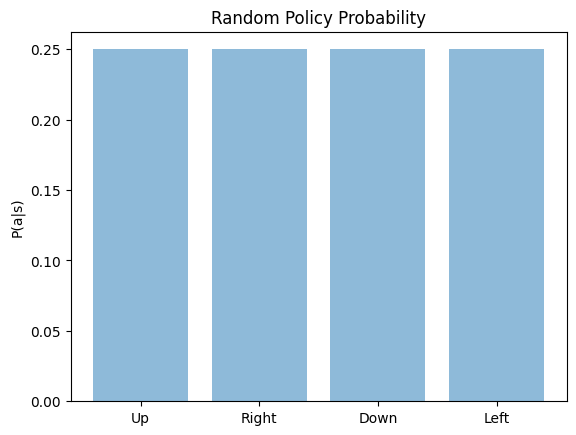

In [17]:
env = Maze()
state, _ = env.reset()

action_probabilities = random_policy(state)

objects = ('Up', 'Right', 'Down', 'Left')
y_pos = np.arange(len(objects))

plt.bar(y_pos, action_probabilities, alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('P(a|s)')
plt.title('Random Policy Probability')
plt.show()

### 3.2 정책을 사용한 에피소드 실행 및 시각화

에이전트가 랜덤하게 움직이며 출구(녹색)를 찾아가는 과정을 시각화한다.

시뮬레이션 종료


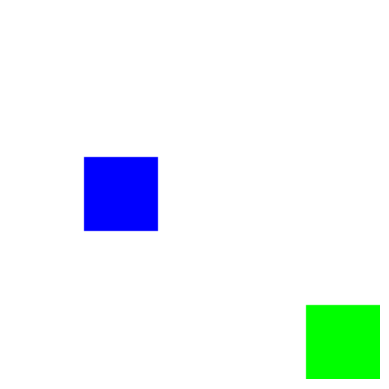

In [18]:
env = Maze()
state, _ = env.reset()
done = False

# 시각화를 위한 초기 이미지 설정
img = plt.imshow(env.render())
plt.axis('off')

step = 0
# 너무 오래 걸릴 수 있으므로 50스텝만 시각화하거나 종료될 때까지 실행
while not done and step < 50:
    # 1. 정책에 따라 행동 선택 (확률 분포 기반 랜덤 선택)
    action = np.random.choice(range(4), 1, p=action_probabilities)[0]

    # 2. 환경에 행동 적용
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    # 3. 화면 갱신
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    step += 1

env.close()
print("시뮬레이션 종료")

> **요약:** 이번 장에서는 Gymnasium을 사용하여 강화학습 환경을 구성하고, MDP의 기본 요소인 상태, 행동, 보상, 궤적, 정책을 코드로 구현하고 확인해보았다. 다음 장에서는 이를 바탕으로 최적의 정책을 찾는 알고리즘들을 다룰 것이다.